## Wasserstein distance

### Using the Wasserstein distance the distribution of the data from the training and test set is compared

In [1]:
import pandas as pd
from pandas import array
import numpy as np
import time
import math
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.dates
from numpy.lib import stride_tricks
from keras.models import Model
from keras.layers import Input, LSTM, Dense, LSTMCell, RNN, Bidirectional, Concatenate, GRU, RepeatVector, TimeDistributed, Dropout, Concatenate, BatchNormalization
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras import callbacks, layers
import tensorflow as tf
print(np.version.version)
print(tf.__version__)

1.24.1
2.11.0


## Data

### Load data set and define variables

In [2]:
windowSize=240

data_row = pd.read_csv("data_st_sm_11_years.csv")

datetime = np.squeeze(data_row["datetime"].to_numpy())
dates = matplotlib.dates.date2num(datetime)

In [3]:

at = np.squeeze(data_row["AirTempHourely"].to_numpy())
pr = np.squeeze(data_row["PrecHourely"].to_numpy())
st05 = np.squeeze(data_row["SoilTempHourely"].to_numpy()) 
sm05 = np.squeeze(data_row["SoilMoiHourely"].to_numpy()) 

### Data normalization

In [28]:
def create_norm_seq(seq):
    seq_norm= (seq-np.min(seq))/(np.max(seq)-np.min(seq))
    return seq_norm

at_norm = create_norm_seq(at)
pr_norm = create_norm_seq(pr)
st05_norm = create_norm_seq(st05)
sm05_norm = create_norm_seq(sm05)

In [29]:
numFeatin = 2
numFeatout = 2

data_norm = np.zeros((len(at),numFeatout+numFeatin))
data_norm[:,0]=at_norm
data_norm[:,1]=pr_norm
data_norm[:,2]=st05_norm
data_norm[:,3]=sm05_norm

### Split data in taining set (7 years) and test set (4 years)

In [30]:
yearly_hours= 365*24
years=7

split = int(windowSize*(np.floor((yearly_hours*years)/windowSize)))
end = int(windowSize*(np.floor((len(data_norm))/windowSize)))

data_train = data_norm[0:split]
data_test = data_norm[split:end]

## Cross validation

### Split training data set for a 4-fold crossvalidation

In [31]:
fold_len = len(data_train)/4

fold_len_div = int(windowSize*(np.floor(fold_len/windowSize)))

In [32]:
data_fold_1 = data_norm[0:fold_len_div]
data_fold_2 = data_norm[fold_len_div:fold_len_div*2]
data_fold_3 = data_norm[fold_len_div*2:fold_len_div*3]
data_fold_4 = data_norm[fold_len_div*3:fold_len_div*4]

### Plot the different folds

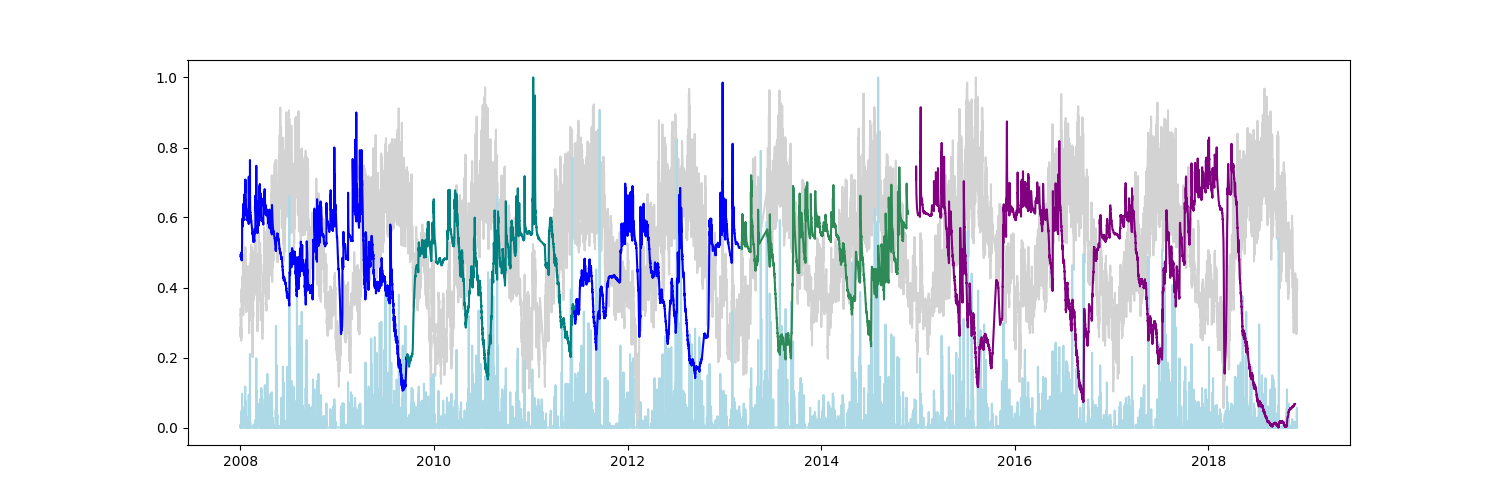

In [33]:
plt.figure(figsize=(15,5))
plt.plot_date(dates,data_norm[:,0],"-",color="lightgrey")
plt.plot_date(dates,data_norm[:,1],"-",color="lightblue")
plt.plot_date(dates[0:fold_len_div],data_fold_1[:,3],"-",color="blue")
plt.plot_date(dates[fold_len_div:fold_len_div*2],data_fold_2[:,3],"-",color="teal")
plt.plot_date(dates[fold_len_div*2:fold_len_div*3],data_fold_3[:,3],"-",color="blue")
plt.plot_date(dates[fold_len_div*3:fold_len_div*4],data_fold_4[:,3],"-",color="seagreen")
plt.plot_date(dates[split:end],data_test[:,3],"-",color="purple")
plt.show()

### Historamm to compare distribution of train set and test set

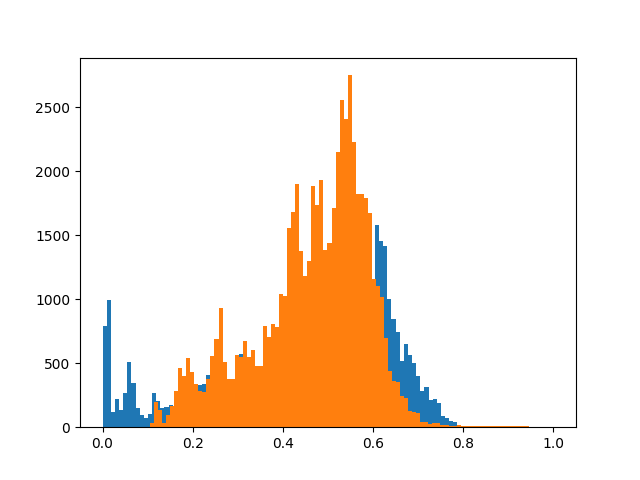

In [26]:
plt.figure()
plt.hist(data_test[:,3],bins=100)
plt.hist(data_norm[0:split,3],bins=100)
plt.show()

### Visualisation of the data distribution in the different years of the test set in comparison to the training set (2008-2014)

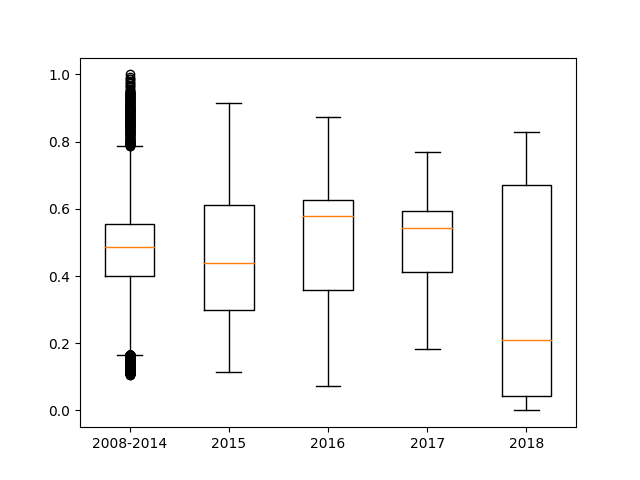

In [27]:

data = [data_norm[0:split,3],data_test[:34320-8760*3,3],data_test[34320-8760*3:34320-8760*2,3],data_test[34320-8760*2:34320-8760,3],data_test[34320-8760:34320,3]]
fig7, ax7 = plt.subplots()
ax7.boxplot(data)
plt.xticks([1, 2, 3, 4, 5], ['2008-2014','2015', '2016',  '2017', '2018'])
plt.show()


## Wasserstein distance

### test set, soil moisture single years

In [12]:
from scipy.stats import wasserstein_distance

counts_train, bins_train = np.histogram(data_norm[0:split,3], bins=300)
counts_2018, bins_2018 = np.histogram(data_test[34320-8760:34320,3], bins=300)
counts_2017, bins_2017 = np.histogram(data_test[34320-8760*2:34320-8760,3], bins=300)
counts_2016, bins_2016 = np.histogram(data_test[34320-8760*3:34320-8760*2,3], bins=300)
counts_2015, bins_2015 = np.histogram(data_test[0:34320-8760*3,3], bins=300)

#print(counts_train.shape)
#print(bins_train[:-1].shape)
print("2018",wasserstein_distance(bins_train[:-1],bins_2018[:-1],counts_train, counts_2018*(sum(counts_train)/sum(counts_2018))))
print("2017",wasserstein_distance(bins_train[:-1],bins_2017[:-1],counts_train, counts_2017*(sum(counts_train)/sum(counts_2017))))
print("2016",wasserstein_distance(bins_train[:-1],bins_2016[:-1],counts_train, counts_2016*(sum(counts_train)/sum(counts_2016))))
print("2015",wasserstein_distance(bins_train[:-1],bins_2015[:-1],counts_train, counts_2015*(sum(counts_train)/sum(counts_2015))))



2018 0.21763313838392487
2017 0.030351517622432433
2016 0.057202927143450544
2015 0.058994301294325716


### test set, air temperature single years

In [13]:
counts_train_at, bins_train_at = np.histogram(data_norm[0:split,0], bins=300)
counts_test_at, bins_test_at = np.histogram(data_test[:,0], bins=300)
counts_2018_at, bins_2018_at = np.histogram(data_test[34320-8760:34320,0], bins=300)
counts_2017_at, bins_2017_at = np.histogram(data_test[34320-8760*2:34320-8760,0], bins=300)
counts_2016_at, bins_2016_at = np.histogram(data_test[34320-8760*3:34320-8760*2,0], bins=300)
counts_2015_at, bins_2015_at = np.histogram(data_test[0:34320-8760*3,0], bins=300)

print("test_at",wasserstein_distance(bins_train_at[:-1],bins_test_at[:-1],counts_train_at, counts_test_at*(sum(counts_train_at)/sum(counts_test_at))))
print("2018_at",wasserstein_distance(bins_train_at[:-1],bins_2018_at[:-1],counts_train_at, counts_2018_at*(sum(counts_train_at)/sum(counts_2018_at))))
print("2017_at",wasserstein_distance(bins_train_at[:-1],bins_2017_at[:-1],counts_train_at, counts_2017_at*(sum(counts_train_at)/sum(counts_2017_at))))
print("2016_at",wasserstein_distance(bins_train_at[:-1],bins_2016_at[:-1],counts_train_at, counts_2016_at*(sum(counts_train_at)/sum(counts_2016_at))))
print("2015_at",wasserstein_distance(bins_train_at[:-1],bins_2015_at[:-1],counts_train_at, counts_2015_at*(sum(counts_train_at)/sum(counts_2015_at))))


test_at 0.015105315303722534
2018_at 0.023810461727824896
2017_at 0.005789378814007625
2016_at 0.014606923799011573
2015_at 0.023299872412125444


### test set, precipitaion single years

In [14]:
counts_train_p, bins_train_p = np.histogram(data_norm[0:split,1], bins=300)
counts_test_p, bins_test_p = np.histogram(data_test[:,1], bins=300)
counts_2018_p, bins_2018_p = np.histogram(data_test[34320-8760:34320,1], bins=300)
counts_2017_p, bins_2017_p = np.histogram(data_test[34320-8760*2:34320-8760,1], bins=300)
counts_2016_p, bins_2016_p = np.histogram(data_test[34320-8760*3:34320-8760*2,1], bins=300)
counts_2015_p, bins_2015_p = np.histogram(data_test[0:34320-8760*3,1], bins=300)

print("test_p",wasserstein_distance(bins_train_p[:-1],bins_test_p[:-1],counts_train_p, counts_test_p*(sum(counts_train_p)/sum(counts_test_p))))
print("2018_p",wasserstein_distance(bins_train_p[:-1],bins_2018_p[:-1],counts_train_p, counts_2018_p*(sum(counts_train_p)/sum(counts_2018_p))))
print("2017_p",wasserstein_distance(bins_train_p[:-1],bins_2017_p[:-1],counts_train_p, counts_2017_p*(sum(counts_train_p)/sum(counts_2017_p))))
print("2016_p",wasserstein_distance(bins_train_p[:-1],bins_2016_p[:-1],counts_train_p, counts_2016_p*(sum(counts_train_p)/sum(counts_2016_p))))
print("2015_p",wasserstein_distance(bins_train_p[:-1],bins_2015_p[:-1],counts_train_p, counts_2015_p*(sum(counts_train_p)/sum(counts_2015_p))))

test_p 0.0005702305280460944
2018_p 0.0012916216231177262
2017_p 0.0004024866493953337
2016_p 0.0008025255675993064
2015_p 0.0010663012289386458


### test set, soil temperature single years 

In [15]:
counts_train_st, bins_train_st = np.histogram(data_norm[0:split,2], bins=300)
counts_test_st, bins_test_st = np.histogram(data_test[:,2], bins=300)
counts_2018_st, bins_2018_st = np.histogram(data_test[34320-8760:34320,2], bins=300)
counts_2017_st, bins_2017_st = np.histogram(data_test[34320-8760*2:34320-8760,2], bins=300)
counts_2016_st, bins_2016_st = np.histogram(data_test[34320-8760*3:34320-8760*2,2], bins=300)
counts_2015_st, bins_2015_st = np.histogram(data_test[0:34320-8760*3,2], bins=300)

print("test_st",wasserstein_distance(bins_train_st[:-1],bins_test_st[:-1],counts_train_st, counts_test_st*(sum(counts_train_st)/sum(counts_test_st))))
print("2018_st",wasserstein_distance(bins_train_st[:-1],bins_2018_st[:-1],counts_train_st, counts_2018_st*(sum(counts_train_st)/sum(counts_2018_st))))
print("2017_st",wasserstein_distance(bins_train_st[:-1],bins_2017_st[:-1],counts_train_st, counts_2017_st*(sum(counts_train_st)/sum(counts_2017_st))))
print("2016_st",wasserstein_distance(bins_train_st[:-1],bins_2016_st[:-1],counts_train_st, counts_2016_st*(sum(counts_train_st)/sum(counts_2016_st))))
print("2015_st",wasserstein_distance(bins_train_st[:-1],bins_2015_st[:-1],counts_train_st, counts_2015_st*(sum(counts_train_st)/sum(counts_2015_st))))

test_st 0.026128388238097346
2018_st 0.036961877366066334
2017_st 0.01854410545554371
2016_st 0.03762119671459992
2015_st 0.037292342370182634


### test set, soil moisture single years

In [16]:
counts_train_sm, bins_train_sm = np.histogram(data_norm[0:split,3], bins=300)
counts_test_sm, bins_test_sm = np.histogram(data_test[:,3], bins=300)
counts_2018_sm, bins_2018_sm = np.histogram(data_test[34320-8760:34320,3], bins=300)
counts_2017_sm, bins_2017_sm = np.histogram(data_test[34320-8760*2:34320-8760,3], bins=300)
counts_2016_sm, bins_2016_sm = np.histogram(data_test[34320-8760*3:34320-8760*2,3], bins=300)
counts_2015_sm, bins_2015_sm = np.histogram(data_test[0:34320-8760*3,3], bins=300)

print("2018_test",wasserstein_distance(bins_train_sm[:-1],bins_test_sm[:-1],counts_train_sm, counts_test_sm*(sum(counts_train_sm)/sum(counts_test_sm))))
print("2018_sm",wasserstein_distance(bins_train_sm[:-1],bins_2018_sm[:-1],counts_train_sm, counts_2018_sm*(sum(counts_train_sm)/sum(counts_2018_sm))))
print("2017_sm",wasserstein_distance(bins_train_sm[:-1],bins_2017_sm[:-1],counts_train_sm, counts_2017_sm*(sum(counts_train_sm)/sum(counts_2017_sm))))
print("2016_sm",wasserstein_distance(bins_train_sm[:-1],bins_2016_sm[:-1],counts_train_sm, counts_2016_sm*(sum(counts_train_sm)/sum(counts_2016_sm))))
print("2015_sm",wasserstein_distance(bins_train_sm[:-1],bins_2015_sm[:-1],counts_train_sm, counts_2015_sm*(sum(counts_train_sm)/sum(counts_2015_sm))))

2018_test 0.08314761211942019
2018_sm 0.21763313838392487
2017_sm 0.030351517622432433
2016_sm 0.057202927143450544
2015_sm 0.058994301294325716


### train set (mean of cross-validation folds), soil moisture and soil temperature

In [17]:
data_fold_1 = data_norm[0:fold_len_div]
data_fold_2 = data_norm[fold_len_div:fold_len_div*2]
data_fold_3 = data_norm[fold_len_div*2:fold_len_div*3]
data_fold_4 = data_norm[fold_len_div*3:fold_len_div*4]

data_train_fold_1 = np.concatenate((data_fold_2, data_fold_3, data_fold_4))
data_train_fold_2 = np.concatenate((data_fold_1, data_fold_3, data_fold_4))
data_train_fold_3 = np.concatenate((data_fold_1, data_fold_2, data_fold_4))
data_train_fold_4 = np.concatenate((data_fold_1, data_fold_2, data_fold_3))

print("soil moisture")

counts_fold1_sm, bins_fold1_sm = np.histogram(data_fold_1[:,3],bins=300)
counts_dat_fold1_sm, bins_dat_fold1_sm = np.histogram(data_train_fold_1[:,3],bins=300)
fold1_sm = wasserstein_distance(bins_dat_fold1_sm[:-1],bins_fold1_sm[:-1],counts_dat_fold1_sm, counts_fold1_sm*(sum(counts_dat_fold1_sm)/sum(counts_fold1_sm)))

counts_fold2_sm, bins_fold2_sm = np.histogram(data_fold_2[:,3],bins=300)
counts_dat_fold2_sm, bins_dat_fold2_sm = np.histogram(data_train_fold_2[:,3],bins=300)
fold2_sm = wasserstein_distance(bins_dat_fold2_sm[:-1],bins_fold2_sm[:-1],counts_dat_fold2_sm, counts_fold2_sm*(sum(counts_dat_fold2_sm)/sum(counts_fold2_sm)))

counts_fold3_sm, bins_fold3_sm = np.histogram(data_fold_3[:,3],bins=300)
counts_dat_fold3_sm, bins_dat_fold3_sm = np.histogram(data_train_fold_3[:,3],bins=300)
fold3_sm = wasserstein_distance(bins_dat_fold3_sm[:-1],bins_fold3_sm[:-1],counts_dat_fold3_sm, counts_fold3_sm*(sum(counts_dat_fold3_sm)/sum(counts_fold3_sm)))

counts_fold4_sm, bins_fold4_sm = np.histogram(data_fold_4[:,3],bins=300)
counts_dat_fold4_sm, bins_dat_fold4_sm = np.histogram(data_train_fold_4[:,3],bins=300)
fold4_sm = wasserstein_distance(bins_dat_fold4_sm[:-1],bins_fold4_sm[:-1],counts_dat_fold4_sm, counts_fold4_sm*(sum(counts_dat_fold4_sm)/sum(counts_fold4_sm)))

print((fold1_sm+fold2_sm+fold3_sm+fold4_sm)/4)

print("soil temperature")

counts_fold1_st, bins_fold1_st = np.histogram(data_fold_1[:,2],bins=300)
counts_dat_fold1_st, bins_dat_fold1_st = np.histogram(data_train_fold_1[:,2],bins=300)
fold1_st = wasserstein_distance(bins_dat_fold1_st[:-1],bins_fold1_st[:-1],counts_dat_fold1_st, counts_fold1_st*(sum(counts_dat_fold1_st)/sum(counts_fold1_st)))

counts_fold2_st, bins_fold2_st = np.histogram(data_fold_2[:,2],bins=300)
counts_dat_fold2_st, bins_dat_fold2_st = np.histogram(data_train_fold_2[:,2],bins=300)
fold2_st = wasserstein_distance(bins_dat_fold2_st[:-1],bins_fold2_st[:-1],counts_dat_fold2_st, counts_fold2_st*(sum(counts_dat_fold2_st)/sum(counts_fold2_st)))

counts_fold3_st, bins_fold3_st = np.histogram(data_fold_3[:,2],bins=300)
counts_dat_fold3_st, bins_dat_fold3_st = np.histogram(data_train_fold_3[:,2],bins=300)
fold3_st = wasserstein_distance(bins_dat_fold3_st[:-1],bins_fold3_st[:-1],counts_dat_fold3_st, counts_fold3_st*(sum(counts_dat_fold3_st)/sum(counts_fold3_st)))

counts_fold4_st, bins_fold4_st = np.histogram(data_fold_4[:,2],bins=300)
counts_dat_fold4_st, bins_dat_fold4_st = np.histogram(data_train_fold_4[:,2],bins=300)
fold4_st = wasserstein_distance(bins_dat_fold4_st[:-1],bins_fold4_st[:-1],counts_dat_fold4_st, counts_fold4_st*(sum(counts_dat_fold4_st)/sum(counts_fold4_st)))

print((fold1_st+fold2_st+fold3_st+fold4_st)/4)

soil moisture
0.034038118416284895
soil temperature
0.060247611159248975


### train set (mean of cross-validation folds), air temperature and precipitation

In [18]:
print("air temperature")

counts_fold1_at, bins_fold1_at = np.histogram(data_fold_1[:,0],bins=300)
counts_dat_fold1_at, bins_dat_fold1_at = np.histogram(data_train_fold_1[:,0],bins=300)
fold1_at = wasserstein_distance(bins_dat_fold1_at[:-1],bins_fold1_at[:-1],counts_dat_fold1_at, counts_fold1_at*(sum(counts_dat_fold1_at)/sum(counts_fold1_at)))

counts_fold2_at, bins_fold2_at = np.histogram(data_fold_2[:,0],bins=300)
counts_dat_fold2_at, bins_dat_fold2_at = np.histogram(data_train_fold_2[:,0],bins=300)
fold2_at = wasserstein_distance(bins_dat_fold2_at[:-1],bins_fold2_at[:-1],counts_dat_fold2_at, counts_fold2_at*(sum(counts_dat_fold2_at)/sum(counts_fold2_at)))

counts_fold3_at, bins_fold3_at = np.histogram(data_fold_3[:,0],bins=300)
counts_dat_fold3_at, bins_dat_fold3_at = np.histogram(data_train_fold_3[:,0],bins=300)
fold3_at = wasserstein_distance(bins_dat_fold3_at[:-1],bins_fold3_at[:-1],counts_dat_fold3_at, counts_fold3_at*(sum(counts_dat_fold3_at)/sum(counts_fold3_at)))

counts_fold4_at, bins_fold4_at = np.histogram(data_fold_4[:,0],bins=300)
counts_dat_fold4_at, bins_dat_fold4_at = np.histogram(data_train_fold_4[:,0],bins=300)
fold4_at = wasserstein_distance(bins_dat_fold4_at[:-1],bins_fold4_at[:-1],counts_dat_fold4_at, counts_fold4_at*(sum(counts_dat_fold4_at)/sum(counts_fold4_at)))

print((fold1_at+fold2_at+fold3_at+fold4_at)/4)

print("precipitation")

counts_fold1_p, bins_fold1_p = np.histogram(data_fold_1[:,1],bins=300)
counts_dat_fold1_p, bins_dat_fold1_p = np.histogram(data_train_fold_1[:,1],bins=300)
fold1_p = wasserstein_distance(bins_dat_fold1_p[:-1],bins_fold1_p[:-1],counts_dat_fold1_p, counts_fold1_p*(sum(counts_dat_fold1_p)/sum(counts_fold1_p)))

counts_fold2_p, bins_fold2_p = np.histogram(data_fold_2[:,1],bins=300)
counts_dat_fold2_p, bins_dat_fold2_p = np.histogram(data_train_fold_2[:,1],bins=300)
fold2_p = wasserstein_distance(bins_dat_fold2_p[:-1],bins_fold2_p[:-1],counts_dat_fold2_p, counts_fold2_p*(sum(counts_dat_fold2_p)/sum(counts_fold2_p)))

counts_fold3_p, bins_fold3_p = np.histogram(data_fold_3[:,1],bins=300)
counts_dat_fold3_p, bins_dat_fold3_p = np.histogram(data_train_fold_3[:,1],bins=300)
fold3_p = wasserstein_distance(bins_dat_fold3_p[:-1],bins_fold3_p[:-1],counts_dat_fold3_p, counts_fold3_p*(sum(counts_dat_fold3_p)/sum(counts_fold3_p)))

counts_fold4_p, bins_fold4_p = np.histogram(data_fold_4[:,1],bins=300)
counts_dat_fold4_p, bins_dat_fold4_p = np.histogram(data_train_fold_4[:,1],bins=300)
fold4_p = wasserstein_distance(bins_dat_fold4_p[:-1],bins_fold4_p[:-1],counts_dat_fold4_p, counts_fold4_p*(sum(counts_dat_fold4_p)/sum(counts_fold4_p)))

print((fold1_p+fold2_p+fold3_p+fold4_p)/4)


air temperature
0.03207196483664761
precipitation
0.0005267380075287787


### Histogramm for comparison of data distribution of soil temperature in the train set and the differnt years in the test set 

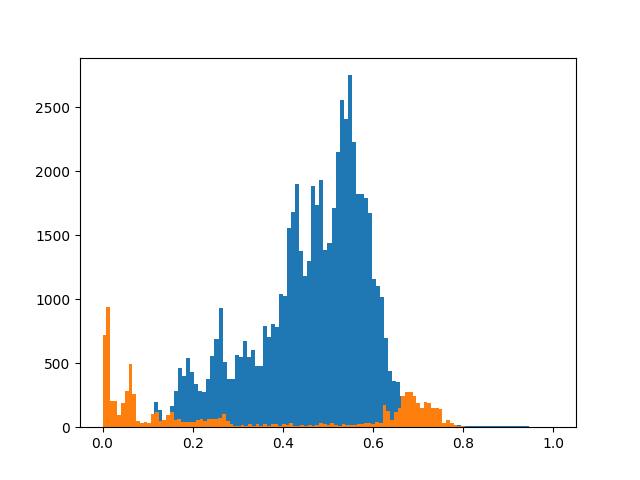

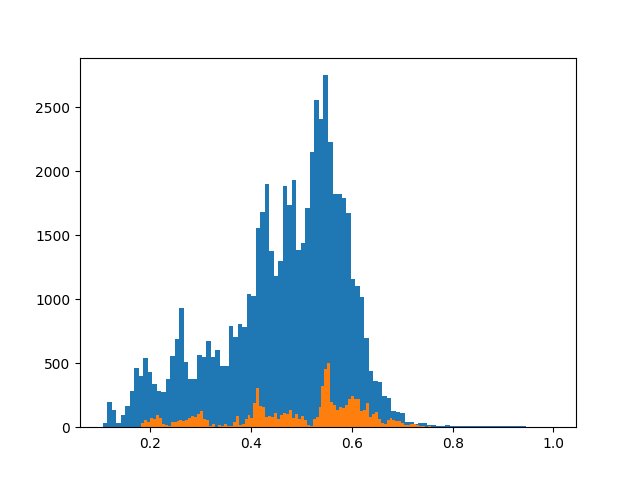

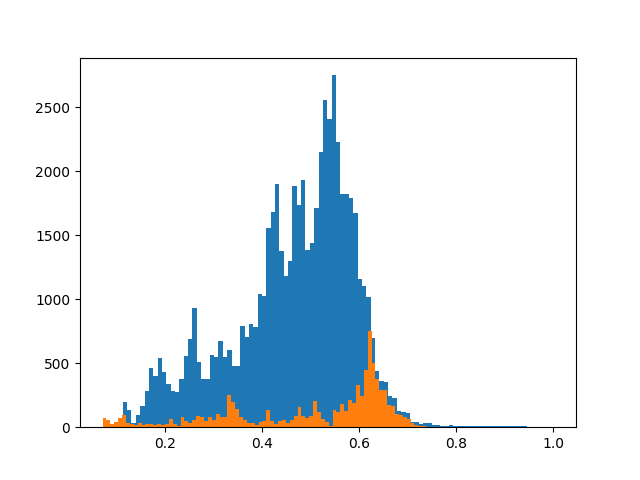

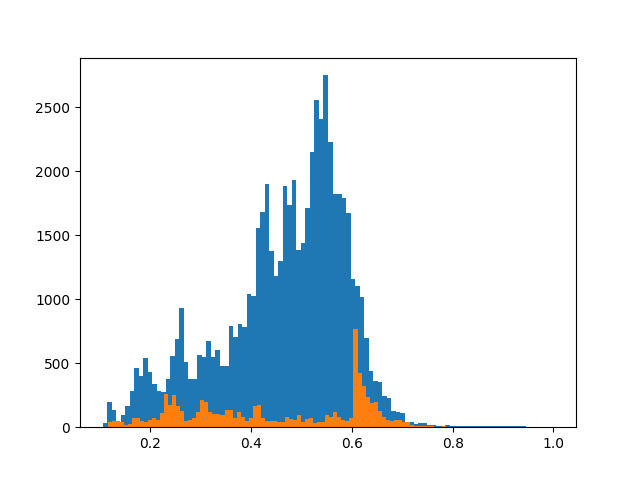

In [19]:
plt.figure()
plt.hist(data_norm[0:split,3],bins=100)
plt.hist(data_test[34320-8760:34320,3],bins=100)
plt.show()

plt.figure()
plt.hist(data_norm[0:split,3],bins=100)
plt.hist(data_test[34320-8760*2:34320-8760,3],bins=100)
plt.show()

plt.figure()
plt.hist(data_norm[0:split,3],bins=100)
plt.hist(data_test[34320-8760*3:34320-8760*2,3],bins=100)
plt.show()

plt.figure()
plt.hist(data_norm[0:split,3],bins=100)
plt.hist(data_test[:34320-8760*3,3],bins=100)
plt.show()